# Advanced Lane Finding Project

This is the fourth project of the self-driving car engineer nanodegree at Udacity. In this project, several videos on the different road conditions, which were recorded by the central camera of a car, were given. We are expected to find lanes in those images (videos).

To this aim, we split the whole process into several steps:

* Compute the camera calibration matrix and distortion coefficients based on a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

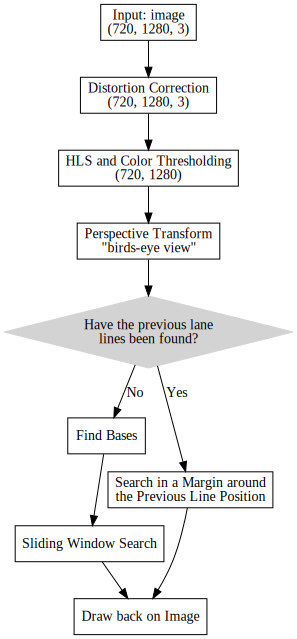

In [1]:
from graphviz import Digraph

dot = Digraph(comment = 'The Round Table')

dot.attr('node', shape='box')
dot.node('A', 'Input: image\n(720, 1280, 3)')
dot.node('B', 'Distortion Correction\n(720, 1280, 3)')
dot.node('C', 'HLS and Color Thresholding\n(720, 1280)')
dot.node('D', 'Perspective Transform\n"birds-eye view"')
dot.node('F1', 'Find Bases')
dot.node('G1', 'Sliding Window Search')
dot.node('F2', 'Search in a Margin around\nthe Previous Line Position')
dot.node('H', 'Draw back on Image')


dot.attr('node', shape='diamond', style='filled', color='lightgrey')
dot.node('E', 'Have the previous lane\nlines been found?')



dot.edges(['AB', 'BC', 'CD', 'DE'])
dot.edge('E', 'F1', label='No')
dot.edge('E', 'F2', label='Yes')
dot.edge('F1', 'G1')
dot.edge('G1', 'H')
dot.edge('F2', 'H')
#dot.edge('B', 'L', constraint='false')
#dot.edge('B', 'L', label ='test')


dot

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

## Step 1. Compute the Camera Calibration Using Chessboard Images

Refer to [Link](https://github.com/fangchun007/Advanced-Lane-Finding/tree/master/camera_cal) for the chessboard images.

**NOTES. **
1. We found that most of the chessboards are of size 9x6, except './camera_cal/calibration1.jpg', './camera_cal/calibration4.jpg', and './camera_cal/calibration5.jpg'. To increase the accuracy of camera calibration, we are going to use them all.

2. The camear calibration will be done only once. The obtained distortion coefficients, such as camera matrix, rotation vectors and transition vectors will be cited in the process of each image.

### Prepare Object Points

In [3]:
# Note that the chessboards (3 exceptions)  we are going to use have size 9x6, the object points
# will be (0,0,0), (1,0,0), ..., (8,5,0)
nx = 9
ny = 6

# Prepare object points
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# './camera_cal/calibration1.jpg': size 9x5
objp1 = np.zeros((9*5, 3), np.float32)
objp1[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)

#'./camera_cal/calibration4.jpg': size 6x5
objp2 = np.zeros((6*5, 3), np.float32)
objp2[:,:2] = np.mgrid[0:6,0:5].T.reshape(-1,2)

#'./camera_cal/calibration5.jpg': size 7x6
objp3 = np.zeros((7*6, 3), np.float32)
objp3[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

### Prepare Image Points from All the Images

In [4]:
# Arrays to store object points and image points from all images.
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Make a list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    # Conver to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow("img", img)
        cv2.waitKey(500)

# Read calibration1.jpg
img = cv2.imread('./camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
if ret == True:
    objpoints.append(objp1)
    imgpoints.append(corners)
    img = cv2.drawChessboardCorners(img, (9,5), corners, ret)
    cv2.imshow("img1", img)
    cv2.waitKey(1000)

# Read calibration4.jpg
img = cv2.imread('./camera_cal/calibration4.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (6,5), None)
if ret == True:
    objpoints.append(objp2)
    imgpoints.append(corners)
    img = cv2.drawChessboardCorners(img, (6,5), corners, ret)
    cv2.imshow("img2", img)
    cv2.waitKey(1000)

# Read calibration5.jpg
img = cv2.imread('./camera_cal/calibration5.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
if ret == True:
    objpoints.append(objp3)
    imgpoints.append(corners)
    img = cv2.drawChessboardCorners(img, (7,6), corners, ret)
    cv2.imshow("img3", img)
    cv2.waitKey(1000)

cv2.destroyAllWindows()

### Camera Calibration

In [5]:
import pickle
import os

# Use the last image `img` information to set the image size
img_size = (img.shape[1], img.shape[0])
# Do camear calibration given object points and image points
# dist: distortion coefficients
# mtx: camera matrix
# rvecs: rotation vectors
# tvecs: transition vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["rvecs"] = rvecs
dist_pickle["tvecs"] = tvecs
if not os.path.exists("./calibration_wide"):
    os.makedirs("./calibration_wide")
pickle.dump(dist_pickle, open("calibration_wide/wide_dist_pickle.p", "wb"))

### Test Module

Use the OpenCV function `cv2.undistort()` to compute the undistortion. Testing images come from [link](https://github.com/fangchun007/Advanced-Lane-Finding/tree/master/test_images).

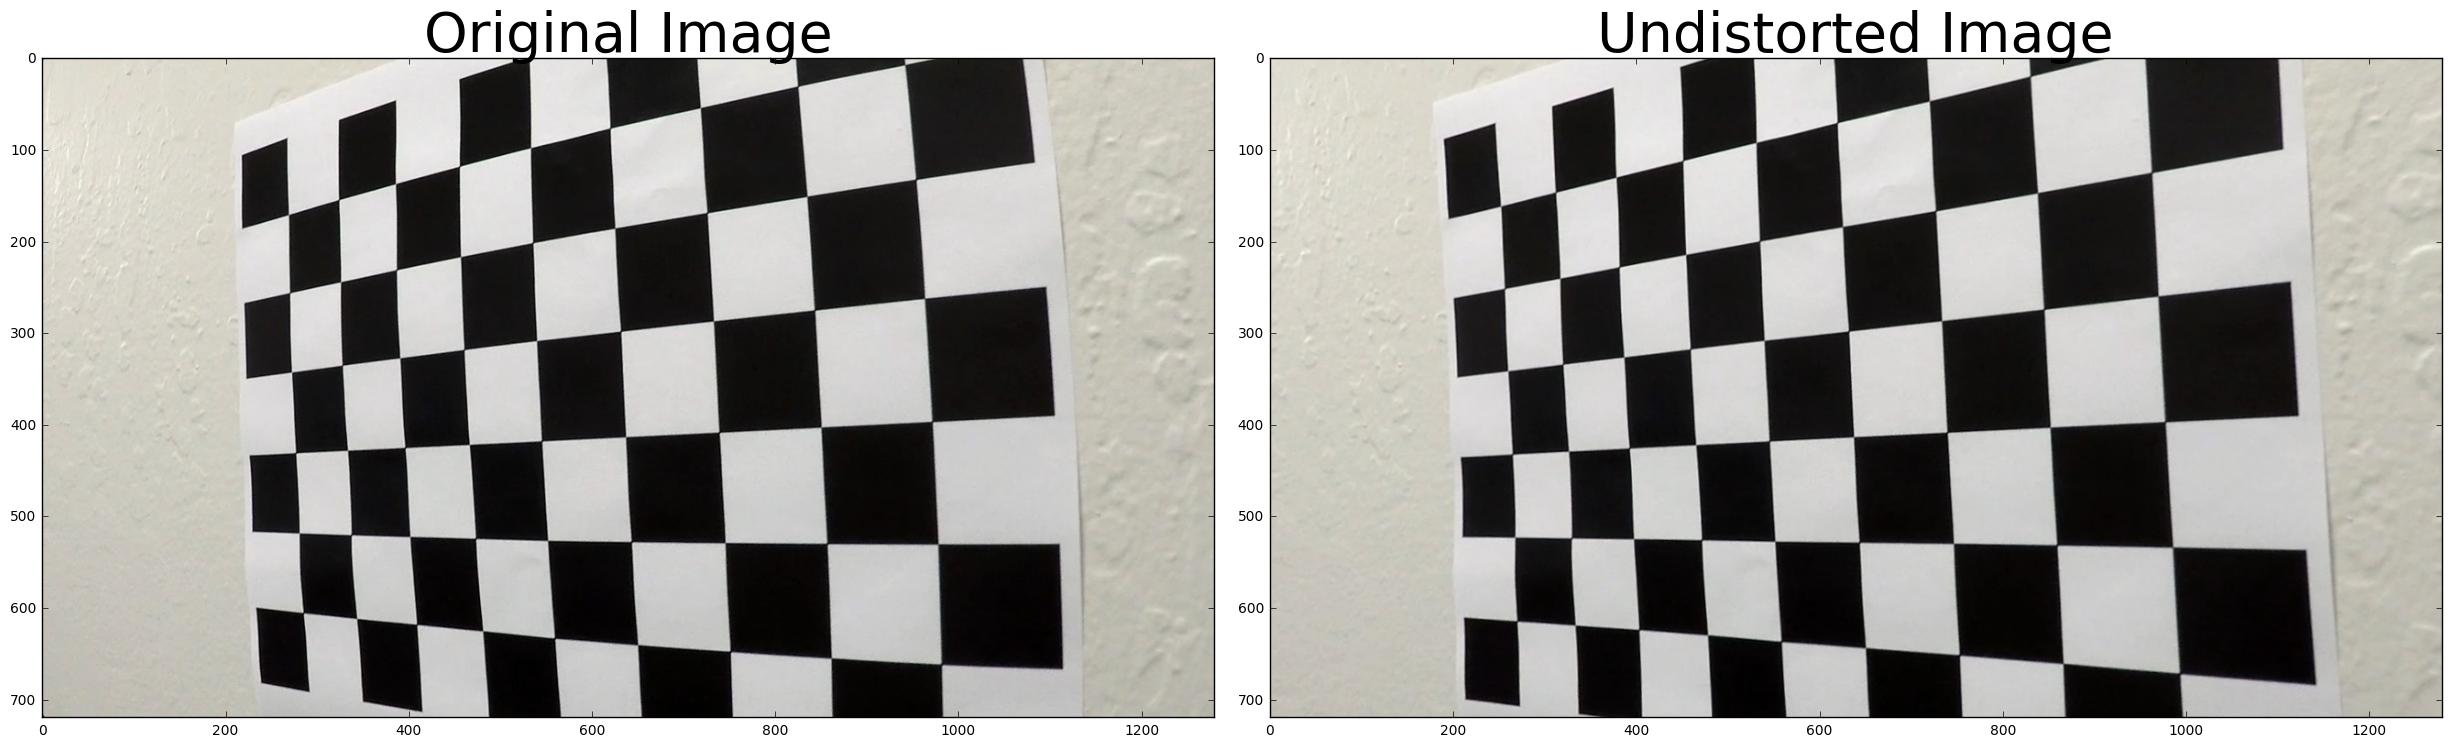

In [6]:
%matplotlib inline

img_example = plt.imread("./camera_cal/calibration4.jpg")
undist_example = cv2.undistort(img_example, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_example)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undist_example)
ax2.set_title('Undistorted Image', fontsize=40)
plt.savefig("./output_images/calibration4_undistort.jpg")
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

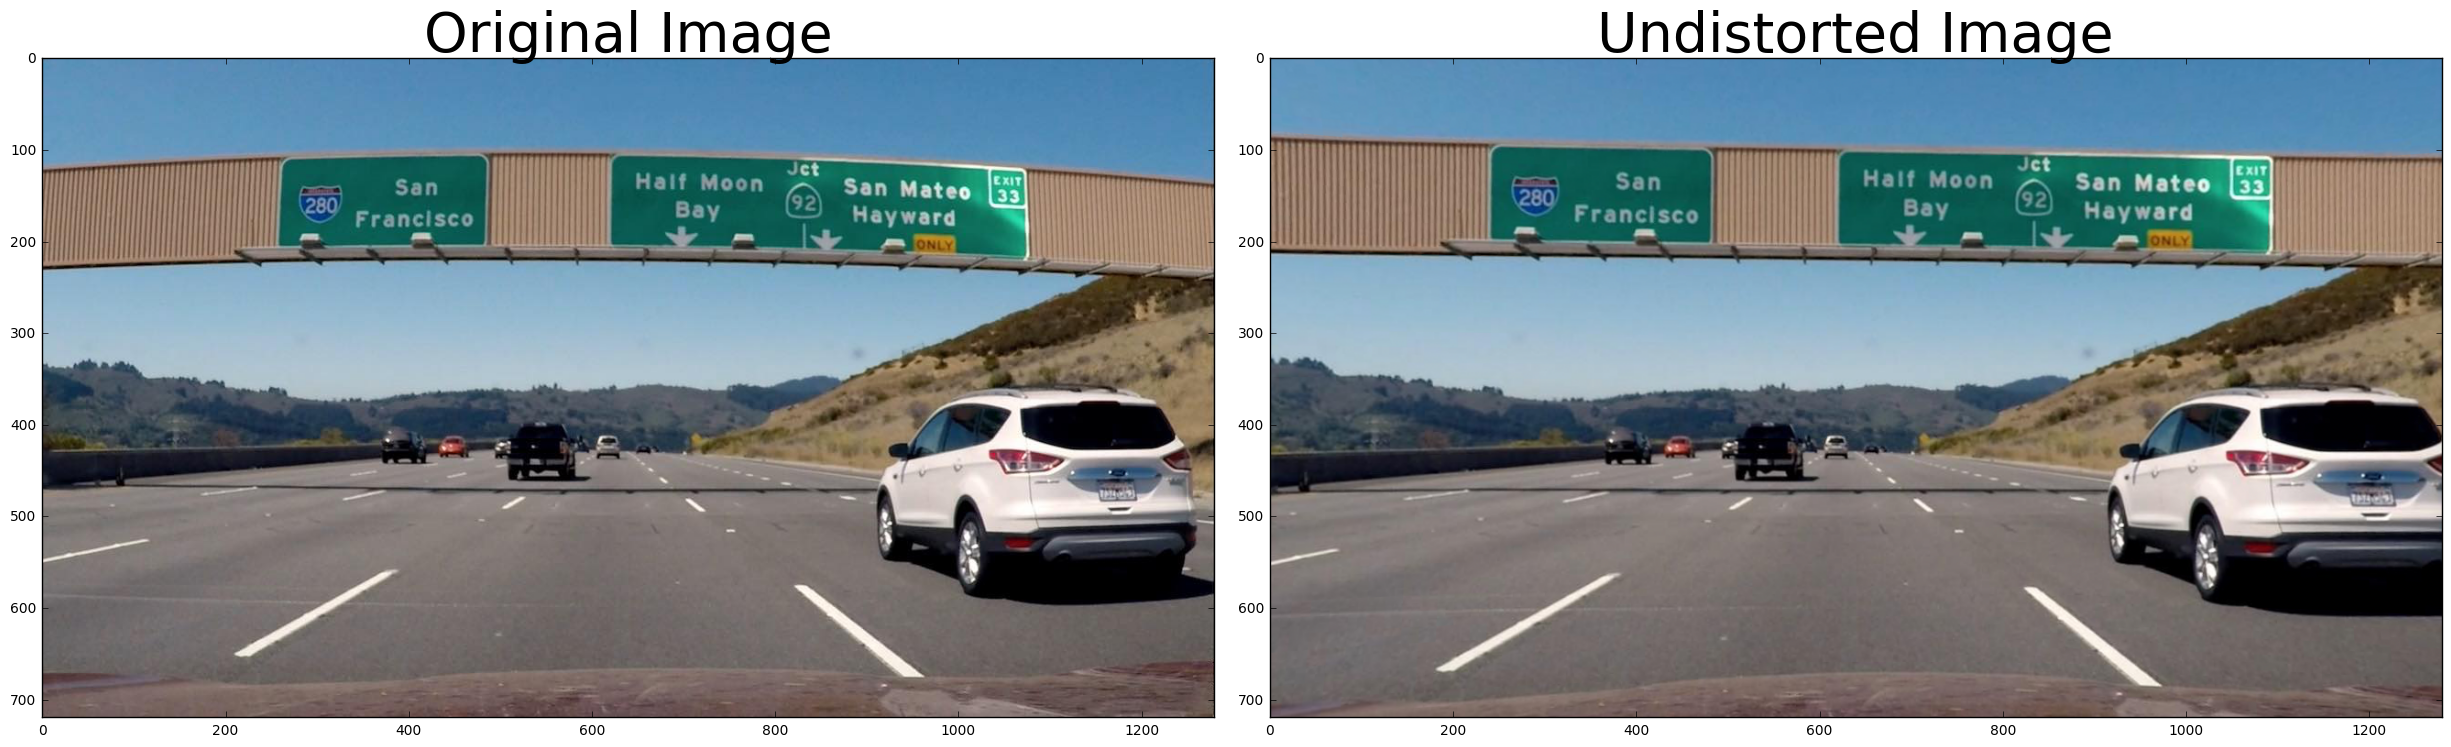

In [7]:
img_example = plt.imread("./test_images/signs_vehicles_xygrad.png")
undist_example = cv2.undistort(img_example, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_example)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undist_example)
ax2.set_title('Undistorted Image', fontsize=40)
plt.savefig("./output_images/signs_vehicles_xygrad_undistort.png")
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**NOTES.** In the following steps, we actually didn't use rotation vectors 'rvecs' and 'tvecs'. And it is not necessary to save these parameters as here, if we only wish to make the next code work. 

**Now consider how you can use various aspects of your gradient measurements (x, y, magnitude, direction) to isolate lane-line pixels.**

* magnitude should be bigger than certain value
* and corresponding direction lies in certain reasonable interval
* use sobel x not sobel y

## Combining Thresholds

After many experiments, we find that 

a). a suitable combination of gradient measurements, such as derivative in the x and y direction, magnitude and direction of the gradient is good for detecting of white lane line. But I didn't find a very nice threshold interval or combination so that they can work on finding yellow lane line and combat with shadows.

b). When s-channel of HLS representation of an image is used to detect lane lines, one can easily find the yellow one. However, this choice is not good for detecting of white lane line and not very good to eliminate heavy shadows.

c). To reliably detect different colors of lane lines under varying degrees of daylight and shadow, we decide to combine the effect of gradients and color selection.

d). We have some subtle modification of normal usages. Please refer to concrete functions.

### Color Thresholding

In [8]:
def hls_select(img, thresh=(182, 250)):
    """
    The image `img` should be 'RGB' format.
    """
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

**NOTES.**
1. Tune `thresh[1]`: the value 255 is a turning point for the image ['frame42sec.jpg'](https://github.com/fangchun007/Advanced-Lane-Finding/blob/master/test_images/frame42sec.jpg). Setting 'thresh[1]==255' will include a lot of shadow boundaries. However, all values satified 'thresh[1] < 255', e.g. 254, lead to eliminating redundant info. Since I didn't observe too much differences between the effects of 'thresh[1]==254' and 'thresh[1] == 250', we set `thresh[1] = 250` on subjective.
2. Tune `thresh[0]`: there is no similar turning point for images as I checked. Basically, values below 170 will lead to more noise, and values bigger than 180 can give me a better feeling. So `thresh[0]` is settled to 182.

### Gradient Thresholding

In [9]:
def abs_sobel_thresh_g(img, orient = 'x', sobel_kernel = 3, thresh = (20, 100)):
    """
    The image `img` should be 'RGB' format. 
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert image to grayscale
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel) # take derivative in x direction
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel) # take derivative in y direction
    abs_sobel = np.absolute(sobel) # take the absolute value of the derivative of gradient
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel)) # scale to 8-bit
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # set the values among the threshold to 1
    return binary_output

**NOTES.**

1. `sobel_kernel`: the value 3 is OK but the result is not very clear. The value 5 is OK for cases without too much shadow. It will include some boundaries of shadows if the shadows increase. The value 9 is not good, even though it works well in the case of no shadow. Sum up,  `sobel_kernel` is settled to 3.

2. If `orient` is `'x'`, set `thresh` to `(20, 100)`. If `orient` is `'y'`, set `thresh` to `(20, 100)`. These result are obtained from experiments. See [here](https://github.com/fangchun007/Advanced-Lane-Finding/tree/master/test_images) for testing images.

### Magnitude Thresholding

In [10]:
def mag_thresh_g(img, sobel_kernel = 3, thresh = (60, 100)):
    """
    The image `img` should be 'RGB' format. 
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert image to grayscale
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel) # gradient along x direction
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel) # gradient along y direction
    mag = np.sqrt(sobelx**2 + sobely**2) # calculate the magnitude
    scaled_mag = np.uint8(255 * mag / np.max(mag)) # scale to 8-bit
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1
    # set the values among the threshold to 1
    return binary_output

**NOTES. **

1. By experiments, 60 is better than 30 for the lower bound of `thresh`. For the upper bound, 100 is OK!
2. 3 is good for the value of `sobel_kernel`. The bigger the value is, more boundaries will be included.

### Direction Thresholding

In [11]:
def dir_thresh_r(img, sobel_kernel = 7, thresh = (0.5, 1.3)):
    """
    The image `img` should be 'RGB' format.
    """
    R = img[:,:,0]
    sobelx = cv2.Sobel(R, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(R, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(angles)
    binary_output[(angles >= thresh[0]) & (angles <= thresh[1])] = 1
    return binary_output

**NOTES.**

1. Threshold intervals '(0.5, 1.3)' is equivalent to '(28.64788975654116, 74.48451336700703)' in degree. It is worth to point out that these degrees are only the description of 'distorted' angles, not real angles.

2. By experiemnts, the r-channel works better than grayscaled image. So the r-channel is used in the direction thresholding.

### Combine Color and Gradient

In [12]:
def gradient(img, sobel_kernels= (3,3,7), sx_thresh=(20,100), sy_thresh=(40,100), 
             mag_thresh=(60,100), dir_thresh=(0.5,1.3)):
    """
    The image `img` should be 'RGB' format
    Graident threshold
    """
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh_g(img, orient='x', sobel_kernel=sobel_kernels[0], thresh=sx_thresh)
    grady = abs_sobel_thresh_g(img, orient='y', sobel_kernel=sobel_kernels[0], thresh=sy_thresh)
    mag_binary = mag_thresh_g(img, sobel_kernel=sobel_kernels[1], thresh=mag_thresh)
    dir_binary = dir_thresh_r(img, sobel_kernel=sobel_kernels[2], thresh=dir_thresh)
    #combinations 
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

In [13]:
def color_and_gradient(img, sobel_kernels=(3,3,7), s_thresh=(182,250), sx_thresh=(20,100), 
                       sy_thresh=(40,100), mag_thresh=(60,100), dir_thresh=(0.5,1.3)):
    """
    The image `img` should be 'RGB' format.
    """
    # s-channel binary output
    s_channel = hls_select(img, thresh=s_thresh)
    # gradient binary output
    gradient_output = gradient(img, sobel_kernels=sobel_kernels, sx_thresh=sx_thresh, 
                               sy_thresh=sy_thresh, mag_thresh=mag_thresh, dir_thresh=dir_thresh)
    # Combine
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel == 1) | (gradient_output == 1)] = 1
    return binary_output



### Test Module

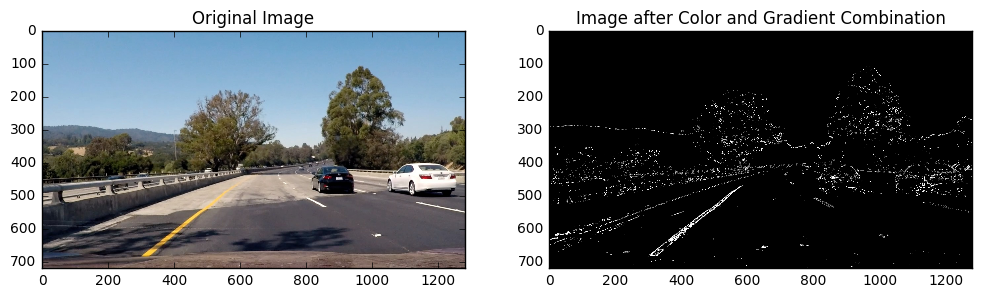

In [14]:
%matplotlib inline

img_example = plt.imread("./test_images/test4.jpg")
img_combined_test = color_and_gradient(img_example)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_example)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(img_combined_test,"gray")
plt.title("Image after Color and Gradient Combination")
plt.savefig("./output_images/color_gradient_test.jpg")

In [15]:
def test(img):
    b_channel = np.uint8(255 * color_and_gradient(img))
    output = np.dstack(( b_channel, b_channel, b_channel))
    return output

In [16]:
from moviepy.editor import VideoFileClip

test_output = 'test_combined.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)
test_clip = clip1.fl_image(test) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

[MoviePy] >>>> Building video test_combined.mp4
[MoviePy] Writing video test_combined.mp4


100%|█████████▉| 1260/1261 [04:48<00:00,  5.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_combined.mp4 

CPU times: user 3min 20s, sys: 1min 10s, total: 4min 30s
Wall time: 4min 49s


## Perspective Transform

Perspective Transform of an image can helps us to obtain the "birds-eye view" of road condition. To compute the perspective transform, we first undistort the image ['test_images/straight_lines2.jpg'](https://github.com/fangchun007/Advanced-Lane-Finding/blob/master/test_images/straight_lines2.jpg). The corresponding result and computer vision functions `cv2.getPerspectiveTransform()` ares used to calculate the perspective transform and its inverse.

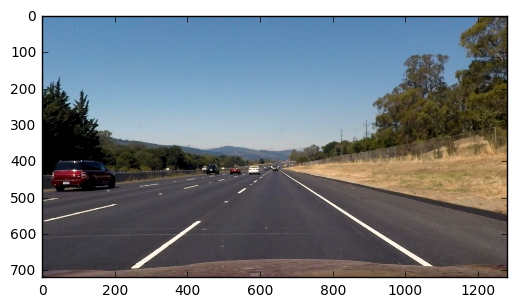

In [17]:
%matplotlib qt

img_for_pt = plt.imread("./test_images/straight_lines2.jpg")
img_for_pt_undist = cv2.undistort(img_for_pt, mtx, dist, None, mtx)

plt.imshow(img_for_pt_undist)

In [18]:
src = np.float32([[558.039, 475.700],
                  [220.665, 719.177],
                  [1106.14, 719.214],
                  [729.26, 475.647]])
dst = np.float32([[300, 0],
                  [300, 720],
                  [980, 720],
                  [980, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

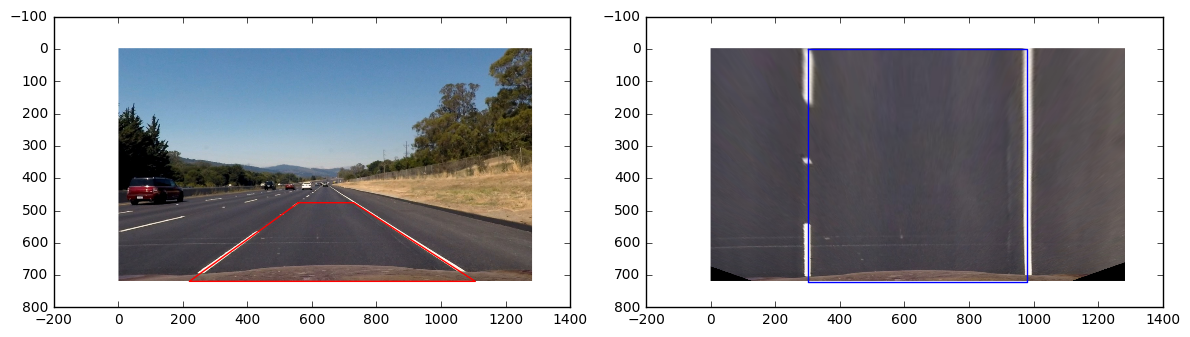

In [23]:
%matplotlib inline

img_for_pt_warped = cv2.warpPerspective(img_for_pt_undist, M, img_size, flags=cv2.INTER_LINEAR)
f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_for_pt_undist)
plt.plot([558.039,220.665,1106.14,729.26,558.039], [475.700, 719.177,719.214,475.647,475.700],'r-')
plt.subplot(1,2,2)
plt.imshow(img_for_pt_warped)
plt.plot([300,300,980,980,300],[0,720,720,0,0])
f.tight_layout()
plt.savefig("./output_images/img_for_pt.jpg")

### Test Module

The computer vision function `cv2.warpPerspective()` is used to obtain the "birds-eye view" image.

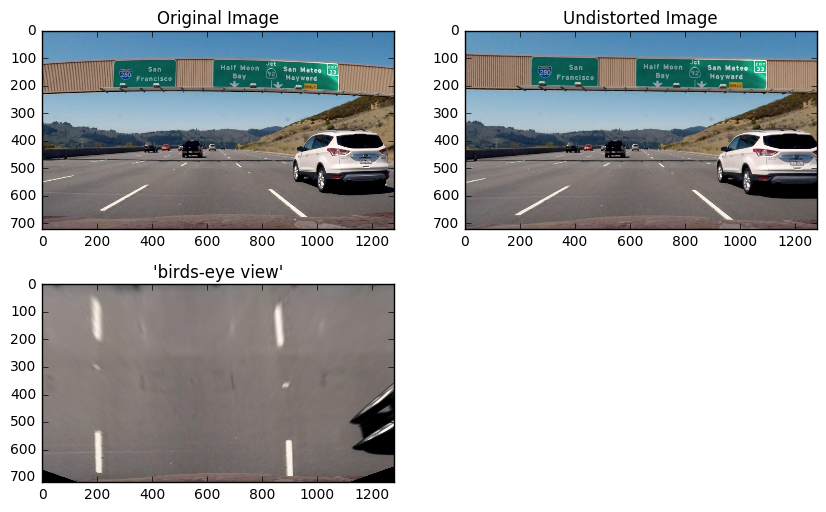

In [24]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
img = plt.imread("./signs_vehicles_xygrad.png")
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2,2,2)
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)
plt.title("Undistorted Image")
plt.subplot(2,2,3)
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)
plt.title("'birds-eye view'")
plt.savefig("./output_images/xygrad_undistort_birdseye.png")

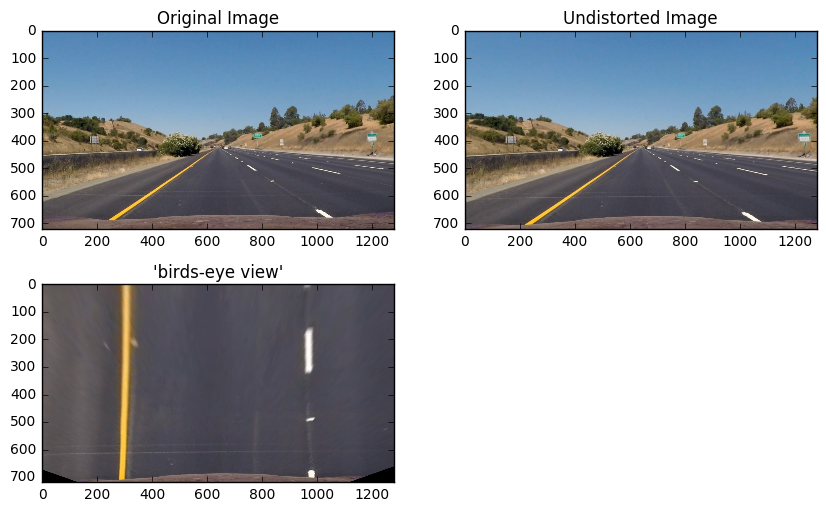

In [25]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
img = plt.imread("./test_images/straight_lines1.jpg")
plt.imshow(img)
plt.title("Original Image")
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(2,2,2)
plt.imshow(undist)
plt.title("Undistorted Image")
plt.subplot(2,2,3)
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)
plt.title("'birds-eye view'")
plt.savefig("./output_images/lines1_undistort_birdseye.jpg")

### Calculation of Metre per Pixel

We use above picture and the fact (US standard) that the lane is about 3.7 meters wide and the dashed lane lines are 10 feet or 3 meters long to calculate convert units from metre to pixel.

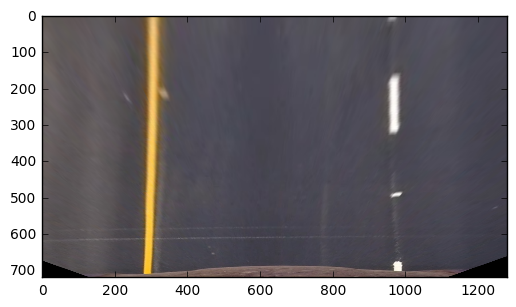

In [26]:
%matplotlib qt
plt.imshow(warped) # warped comes from above cell.

By observation, the interval ([965.38, 965.306], [160.522, 320.145]) corresponds to 3 metres, which can define the unit (meter per pixel) in y direction. And, coordinates (288.782, 719.084) and (977.242, 719.053) are the endpoints of left lane line and right lane line, respectively.

In [27]:
ym_per_pixel = 3./(320.145-160.522)
xm_per_pixel = 3.7/(977.242-288.782)

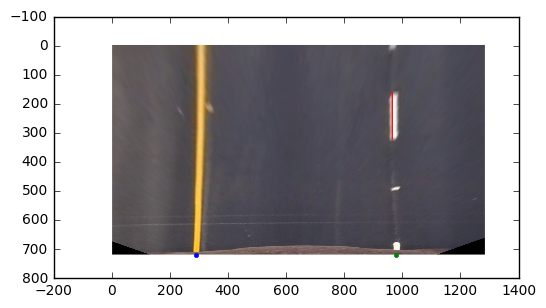

In [28]:
%matplotlib inline

plt.imshow(warped)
plt.plot([965.38, 965.306], [160.522, 320.145], 'r-')
plt.plot(288.782, 719.084, '.')
plt.plot(977.242, 719.053, '.')
plt.savefig("./output_images/m2pixel.jpg")

## Image Process (a brief summary)

We are going package all above actions on image into one function. Namely, given an image, we

* first apply the camera calibration matrix and distortion coefficients to get an undistort image;
* next apply (gradient and color) thresholds to create a binary image;
* then apply a perspective transform to obtain a "birds-eye view".

In [29]:
def process_image(img, camera_matrix=mtx, distortion=dist, p_transform=M, img_size = img_size):
    """
    Give an image obtained from car's camera, the function will process the following steps 
    in order:
    1. undistort: (height, width, n_channels)
    2. apply thresholds to create a binary image: (height, width)
    3. apply perspective transform: (height, width)
    """
    # Undistort using camera matrix and distortion coefficients
    undist = cv2.undistort(img, camera_matrix, distortion, None, camera_matrix)
    # Apply thresholds to create a binary image
    # go to the function 'color_and_gradient' for adjusting parameters 
    binary_thresholds = color_and_gradient(undist)
    # Apply a perspective transform
    binary_warped = cv2.warpPerspective(binary_thresholds, p_transform, img_size, flags=cv2.INTER_LINEAR)
    return binary_warped


### Test Module

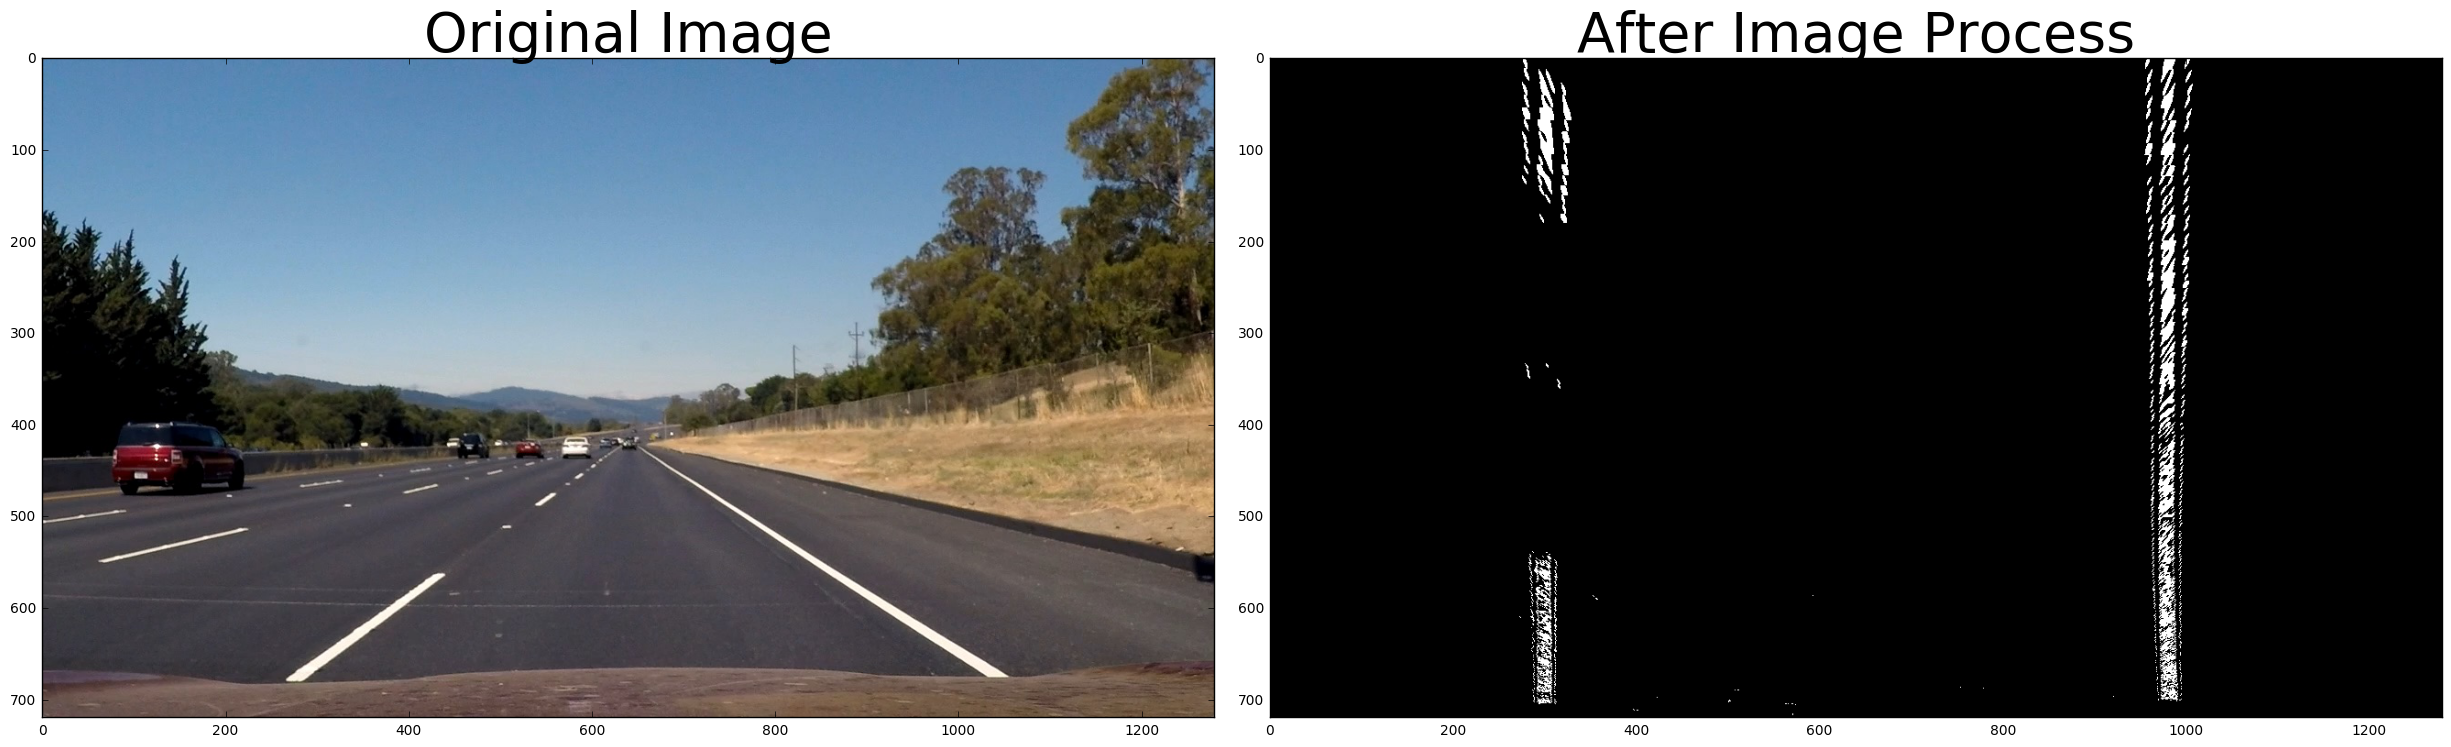

In [30]:
# Test on "./test_images/straight_lines2.jpg"

%matplotlib inline

img_example = plt.imread("./test_images/straight_lines2.jpg")
binary_warped = process_image(img_example)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_example)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(binary_warped, "gray")
ax2.set_title('After Image Process', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/image_process_test.jpg")

In [31]:
# Visualization of image process
def process_image_test(img):
    b_channel = np.uint8(255 * process_image(img))
    output = np.dstack((b_channel, b_channel, b_channel))
    return output

from moviepy.editor import VideoFileClip

output = 'process_image_test.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)
process_image_clip = clip1.fl_image(process_image_test)
%time process_image_clip.write_videofile(output, audio=False)

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))
    

[MoviePy] >>>> Building video process_image_test.mp4
[MoviePy] Writing video process_image_test.mp4


100%|█████████▉| 1260/1261 [06:01<00:00,  3.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: process_image_test.mp4 

CPU times: user 4min 43s, sys: 1min 9s, total: 5min 52s
Wall time: 6min 2s


## Lane Line Detecting

We split the possible situations into two cases.

* Case One: there is no lane line information for previous frame or for previous several frames. In this case, we first use histogram to find out the left and right bases. Then sliding window search techniques are used to find the lane lines.
* Case Two: lane lines were detected for several previous frames. In this case, we search in a margin around the previous line position.

In [32]:
# The following function will be only used in the initialize lane line finding
def find_bases(binary_warped):
    """
    Suppose both left and right lane lines are exist and they are basically 
    straight. This function use histogram to find out the left and right bases.
    :param binary_warped: it has shape (height, width)
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

In [33]:
def initialize_lane_line(binary_warped, nwindows=9, margin=100, minpix=50):
    """
    It is used to initialize lane line, supose that both left and right
    lane lines are appeared in the image and are basicall straight. 
    :param margin: the width of the windows +/- margin
    :param minpix: minimum number of pixels found to recenter window
    :return: left and right lane line pixel positions
    """
    # Take a histogram of the bottom half of the image------
    #leftx_base, rightx_base = find_bases(binary_warped)-----
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current, rightx_current = find_bases(binary_warped)
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & 
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) &
                           (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty

In [34]:
# Fit a second order polynomial to detected lane line.
def polynomial_fit(x, y, order = 2):
    # What if x and y are empty sets?
    if x is None or y is None or (np.min([len(x), len(y)]) == 0):
        return None
    return np.polyfit(y, x, order)

In [35]:
# Assume we now have a new warped binary image obtained from the next frame
# of video. Suppose it has the same name "binary_warped". We try to use 
# results obtained from last frame to find lanes from this frame.

def find_lane_lines(binary_warped, left_fit_pre, right_fit_pre, margin=100):
    """
    This function is used to find the lane lines of current image suppose we 
    already know the lane line fits in the previous image.
    :param left_fit_pre: coefficient of the 2-nd order polynomial fit to the 
    left lane of the previous image
    :param right_fit_pre: coefficient of the 2-nd order polynomial fit to the 
    right lane of the previous image
    """
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit_pre[0]*(nonzeroy**2) + 
                                   left_fit_pre[1]*nonzeroy + 
                                   left_fit_pre[2] - 
                                   margin)) &
                      (nonzerox < (left_fit_pre[0]*(nonzeroy**2) + 
                                   left_fit_pre[1]*nonzeroy + 
                                   left_fit_pre[2] + 
                                   margin))) 
    right_lane_inds = ((nonzerox > (right_fit_pre[0]*(nonzeroy**2) + 
                                    right_fit_pre[1]*nonzeroy + 
                                    right_fit_pre[2] - 
                                    margin)) & 
                       (nonzerox < (right_fit_pre[0]*(nonzeroy**2) + 
                                    right_fit_pre[1]*nonzeroy + 
                                    right_fit_pre[2] + 
                                    margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

### Test Module

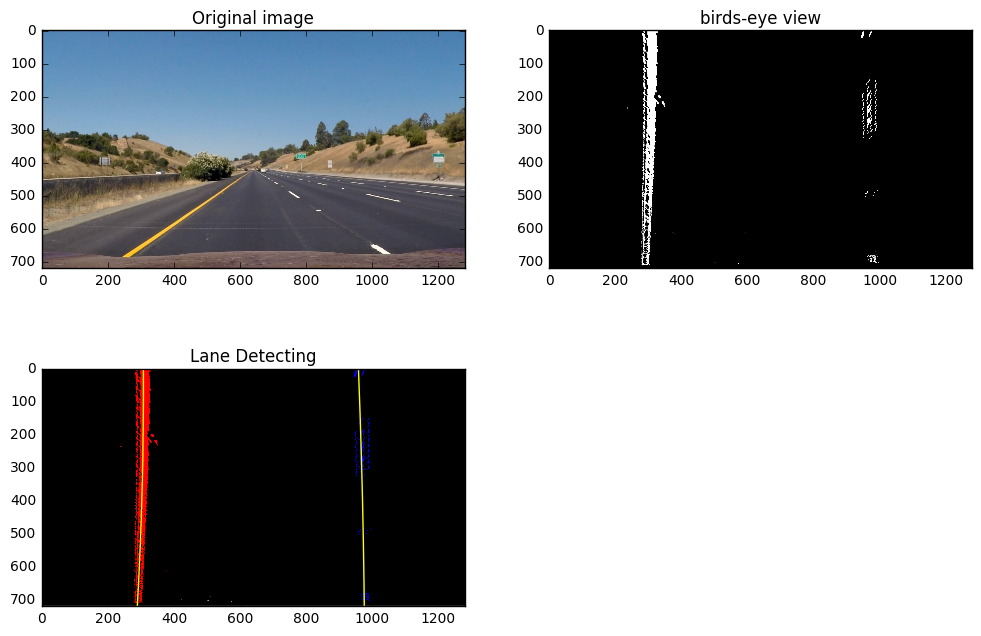

In [36]:
# Sample test One
%matplotlib inline 

img = plt.imread("./test_images/straight_lines1.jpg")
binary_warped = process_image(img)

leftx, lefty, rightx, righty = initialize_lane_line(binary_warped)

left_fit = polynomial_fit(leftx, lefty, 2)
right_fit = polynomial_fit(rightx, righty, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title("Original image")
plt.subplot(2,2,2)
plt.imshow(binary_warped, "gray")
plt.title("birds-eye view")
plt.subplot(2,2,3)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title("Lane Detecting")
plt.savefig("./output_images/lane_detecting_test.jpg")

## Measure Curvature

In [37]:
def measure_curvature(fit, ym_per_pix=ym_per_pixel, xm_per_pix=xm_per_pixel, y_eval=719):
    """
    This function is used for images who has height 720.
    :param ym_per_pix: meters per pixel in y dimension
    :param xm_per_pix: meters per pixel in x dimension
    :return: curvature in meters
    """
    y = np.linspace(0, 719, num=720)
    x = fit[0] * y**2 + fit[1] * y + fit[2]

    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    return ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

## Estimate Vehicle Position

In [38]:
def position(left_fit, right_fit, xm_per_pix=xm_per_pixel):
    # Mathematically, we estimate the vehicle position when y = img.shape[0]
    if left_fit is None or right_fit is None:
        return None
    y = 719
    left_lane = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_lane = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    mid_position = (right_lane + left_lane)/2
    vehicle_position = (1280/2 - mid_position)*xm_per_pix
    return vehicle_position

### Test Module

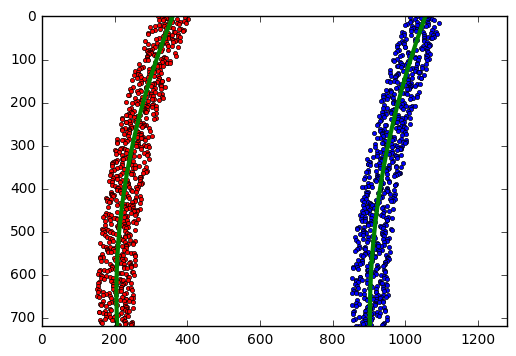

In [39]:
# Test: Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [40]:
# Test continue
y_eval = np.max(ploty)
fit_left = np.polyfit(ploty, leftx, 2)
fit_right = np.polyfit(ploty, rightx, 2)
left_curverad = measure_curvature(fit_left, y_eval = y_eval)
right_curverad = measure_curvature(fit_right, y_eval= y_eval)
vehicle_position = position(fit_left, fit_right)
print(left_curverad, 'm', right_curverad, 'm')
print("Vehicle is now {:.2f}m Away from the Center".format(vehicle_position))

87.5630257529 m 105.402080214 m
Vehicle is now 0.46m Away from the Center


## Image Pipeline

Once we have a good measurement of the line positions in warped space, it's time to project the measurement back down onto the road! 

In the following, we will package all processes in one function `image_pipeline()`.

To obtain a persistent result, the lane lines information of the previous `n` frames will be used to get the current lane line fitting. In our project, `n` is set to 5. `left_fit_pre` and `right_fit_pre` are used to save the previous 2 degree polynomial fitting for corresponding detected lane lines.

In [41]:
n = 5 
left_fit_pre = [None]*n
right_fit_pre = [None]*n

In [42]:
def coeff_correction(left_fit, right_fit, left_fit_pre1, right_fit_pre1):
    l = len(left_fit_pre1)
    total = 1
    left_fit_new = left_fit
    right_fit_new = right_fit
    for i in range(l-1, 0, -1):
        if left_fit_pre1[i] is None or right_fit_pre1[i] is None:
            continue
        else:
            left_fit_new = np.add(left_fit_new, left_fit_pre1[i])
            right_fit_new = np.add(right_fit_new, right_fit_pre1[i])
            total += 1
    return left_fit_new/total, right_fit_new/total

In [43]:
def load_message(img, curvature_left, curvature_right, vehicle_position):
    """
    load present curve radius onto the given image.
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature = np.mean([curvature_left, curvature_right])
    cv2.putText(img, 'Turning Radius = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "Center" 
    if vehicle_position < 0:
        left_or_right = "Left"
    if vehicle_position > 0:
        left_or_right = "Right"
    cv2.putText(img, 'Vehicle is %.2fm %s of Center' % (np.abs(vehicle_position), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)

In [44]:
def image_pipeline(file, filepath=False):
    
    global left_fit_pre
    global right_fit_pre
    global n
    plt.clf()
    
    if filepath == True:
        # Read in image
        img = cv2.imread(file)
    else:
        img = file

    #undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary_warped = process_image(img)
    
    if (left_fit_pre == [None]*n) & (right_fit_pre == [None]*n):
        leftx, lefty, rightx, righty = initialize_lane_line(binary_warped)
    else: 
        # I suppose otherwise both left and right fit are non-empty
        left_fit_former = left_fit_pre[n-1]
        right_fit_former = right_fit_pre[n-1]
        leftx, lefty, rightx, righty = find_lane_lines(binary_warped, 
                                                       left_fit_pre=left_fit_former, 
                                                       right_fit_pre=right_fit_former)
    left_fit = polynomial_fit(leftx, lefty, 2)
    right_fit = polynomial_fit(rightx, righty, 2)
    
    del left_fit_pre[0]
    del right_fit_pre[0]
    
    #left_fit_new = coeff_correction(left_fit, left_fit_pre)
    #right_fit_new = coeff_correction(right_fit, right_fit_pre)
    left_fit_new, right_fit_new = coeff_correction(left_fit, right_fit, left_fit_pre, right_fit_pre)
    
    left_fit_pre.append(left_fit_new)
    right_fit_pre.append(right_fit_new)
    
    # Calculate curvature
    curvature_left = measure_curvature(left_fit_new)
    curvature_right = measure_curvature(right_fit_new)    
    
    # Estimate vehicle position
    vehicle_position = position(left_fit=left_fit_new, right_fit=right_fit_new )
    
    ploty = np.linspace(0, img.shape[0]-1, num=img.shape[0])
    left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    #result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    
    # Record the average curvature info
    load_message(result, curvature_left, curvature_right, vehicle_position)
    
    return result

### Test Module

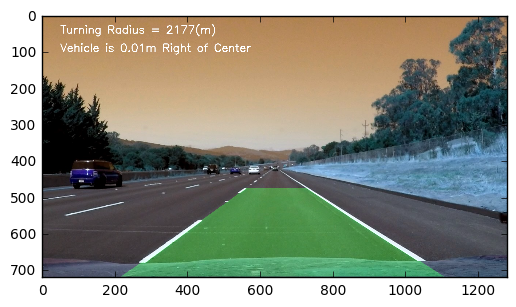

In [45]:
#Image Test
%matplotlib inline

result = image_pipeline(file = "./test_images/straight_lines2.jpg", filepath=True)
plt.imshow(result)
plt.savefig("./output_images/pipeline_output_test.jpg")

## RESULT

In [46]:
# Test Visualization Test
n = 5 
left_fit_pre = [None]*n
right_fit_pre = [None]*n

from moviepy.editor import VideoFileClip

output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)
project_clip = clip1.fl_image(image_pipeline)
%time project_clip.write_videofile(output, audio=False)

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))
    

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [07:15<00:00,  3.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 6min, sys: 1min 40s, total: 7min 40s
Wall time: 7min 17s
